# Using LSTM to predict Alibaba Stock Price 

In [158]:
# import dependencies

from pandas_datareader import data
import pandas as pd
import datetime as dt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time #helper libraries
import urllib.request,json
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

In [209]:
    api_key = '09LQ4XGVZJ2RUVVK'

    # 阿里巴巴美股
    ticker = "BABA"
    #从Alphavantage 得到alibaba数据在workingpath存为csv, load到dataframe里面
    # JSON file 
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [210]:
df = df.sort_values('Date')
#阿里巴巴 14年9月19日在纽交所上市，最新的数据是5月4日
df.head(5)


,Unnamed: 0,Date,Low,High,Close,Open
1414,0,2014-09-19,89.95,99.70,93.89,92.70
1413,1,2014-09-22,89.50,92.95,89.89,92.70
1412,2,2014-09-23,86.62,90.48,87.17,88.94
1411,3,2014-09-24,87.22,90.57,90.57,88.47
1410,4,2014-09-25,88.50,91.50,88.92,91.09


In [211]:
df.tail(5)

,Unnamed: 0,Date,Low,High,Close,Open
4,1410,2020-04-28,199.407,205.19,201.15,204.81
3,1411,2020-04-29,202.510,207.08,206.70,202.93
2,1412,2020-04-30,199.290,206.70,202.67,206.25
1,1413,2020-05-01,192.860,197.38,194.48,195.75
0,1414,2020-05-04,190.150,195.00,190.45,194.76


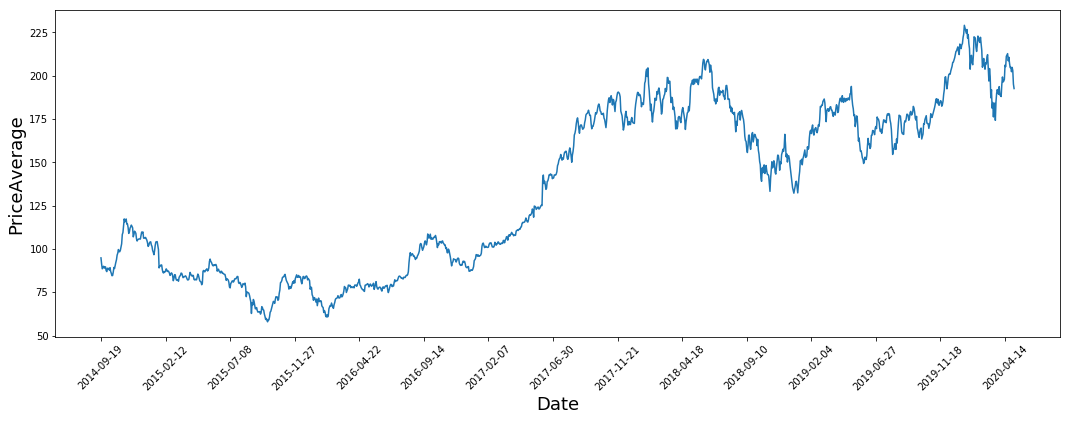

In [196]:
plt.figure(figsize = (18,6))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('PriceAverage',fontsize=18)
plt.show()

([<matplotlib.axis.XTick at 0x1af20f38860>,
 <a list of 29 Text xticklabel objects>)

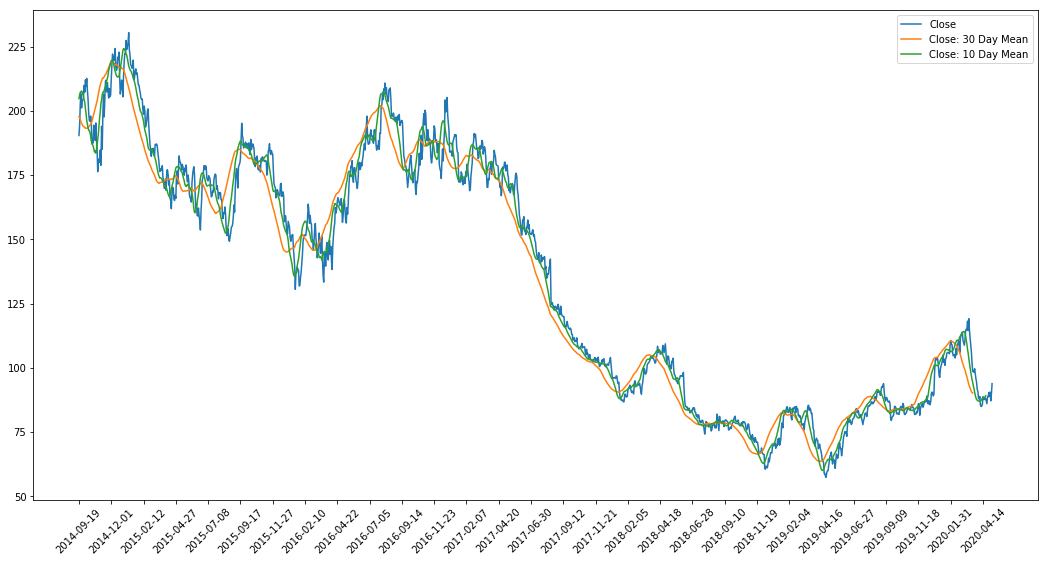

In [213]:
#Using Moving Average
df['Close: 30 Day Mean'] = df['Close'].rolling(30).mean().shift()
df['Close: 10 Day Mean'] = df['Close'].rolling(10).mean().shift() 
df['Close: 20 Day Mean'] = df['Close'].rolling(20).mean().shift()
df[['Close','Close: 30 Day Mean','Close: 10 Day Mean']].plot(figsize=(18,9))
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)

In [198]:
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

train_data = mid_prices[:1100]
test_data = mid_prices[1100:]

# Normalize: Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [199]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 250
for di in range(0,1000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [200]:
#shape back the data
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [201]:
#EMA :perform exponential moving average smoothing for training data
EMA = 0.0
gamma = 0.1
for ti in range(1100):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


MSE error for EMA averaging: 0.00033


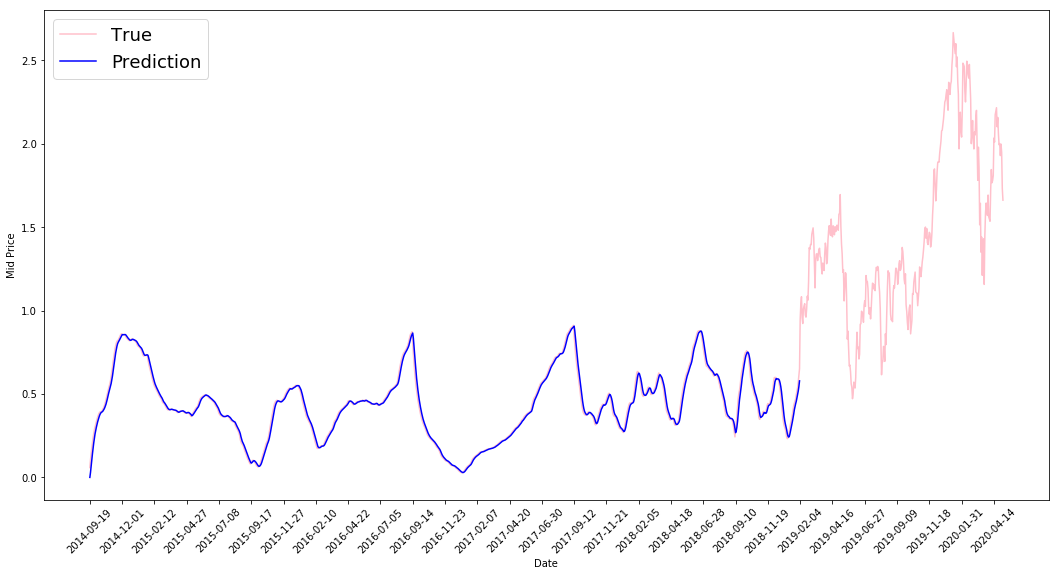

In [203]:
#EMA in one step ahead prediction
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

#plot the result
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='pink',label='True')
plt.plot(range(0,N),run_avg_predictions,color='blue', label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [214]:
#Using LSTM
price=df["Close"].values.astype('float32')

price = price.reshape(1415, 1)
#plt.plot(price)
#plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
price = scaler.fit_transform(price)
train_size = int(len(price) * 0.80)
test_size = len(price) - train_size
train, test = price[0:train_size,:], price[train_size:len(price),:]
print(len(train), len(test))

1132 283


In [159]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.07080912590026855


In [160]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=10,
    validation_split=0.05)

Instructions for updating:
Use tf.cast instead.
Train on 1073 samples, validate on 57 samples
Epoch 1/10
1073/1073 [==============================] - 1s 934us/step - loss: 0.1582 - val_loss: 0.2504
Epoch 2/10
1073/1073 [==============================] - 0s 63us/step - loss: 0.0941 - val_loss: 0.1358
Epoch 3/10
1073/1073 [==============================] - 0s 75us/step - loss: 0.0501 - val_loss: 0.0604
Epoch 4/10
1073/1073 [==============================] - 0s 68us/step - loss: 0.0314 - val_loss: 0.0272
Epoch 5/10
1073/1073 [==============================] - 0s 92us/step - loss: 0.0243 - val_loss: 0.0167
Epoch 6/10
1073/1073 [==============================] - 0s 96us/step - loss: 0.0184 - val_loss: 0.0128
Epoch 7/10
1073/1073 [==============================] - 0s 73us/step - loss: 0.0127 - val_loss: 0.0072
Epoch 8/10
1073/1073 [==============================] - 0s 85us/step - loss: 0.0073 - val_loss: 0.0030
Epoch 9/10
1073/1073 [==============================] - 0s 94us/step - loss: 0.00

In [185]:
predictions = model.predict(testX)
predictions=scaler.inverse_transform(predictions)
realprice=scaler.inverse_transform(testY.reshape(-1,1))

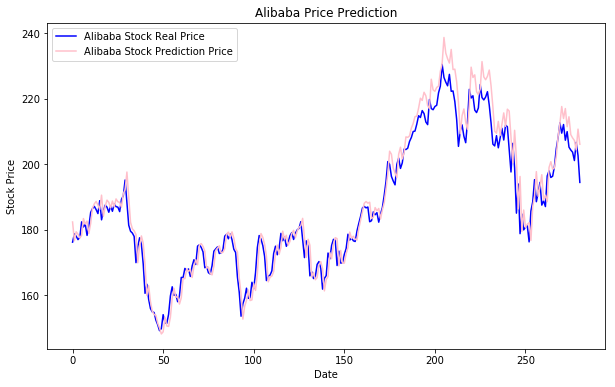

In [205]:
plt.figure(figsize=(10,6))
plt.plot(realprice, color='blue', label='Alibaba Stock Real Price')
plt.plot(predictions , color='pink', label='Alibaba Stock Prediction Price')
plt.title('Alibaba Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()